This code is for ilustion of using tensorRT.  
Do not ask me for the models, they are private dataset.

Although NextVIT[1] itself provide code for tensorRT deployment, they are using ONNX + trtexec pipeline, which is more difficult to use in kaggle notebook. Here we are using torch-tensorRT pipeline from @tivfrvqhs5[2]. We use padding to trt compiled batch size for "dynamic batching".


[1] https://github.com/bytedance/Next-ViT  
[2] https://www.kaggle.com/code/tivfrvqhs5/torch-tensorrt-infer-fp16-and-fp32-benchmarks/notebook  

some modification needs to be made to the nextvit.py code from [1]:
```
[remove]    #if not torch.onnx.is_in_onnx_export() and not self.is_bn_merged:  
[add]       if not self.is_bn_merged:  

```

```
[remove]
            #if self.use_checkpoint:
            #    x = checkpoint.checkpoint(layer, x)
            #else:
```

in development use the function to generate and save the trt engine file 'kaggle-nextvit-b-1536-gpu-aug0-01-swa.trt_fp16.ts'. It may take some time.

Note that tenorRT generates engine file according to the GPU present. So you cannot do this locally in the PC (unless your GPU is the same as kaggle notebook). You must use kaggle notebook to generate  it.

```

    model.encoder.merge_bn() 
    trt_model_fp16 = torch_tensorrt.compile() ...
    
```
In deployment and submission, just use the saved engine file.


----

version9: public share of this notebook (4hr submission)  

version10: improved speed dicom reader (1.5x faster). maybe a little loss of accuracy as it now comes different from the dicom reader used for training.  



In [1]:
#https://www.kaggle.com/code/tivfrvqhs5/torch-tensorrt-infer-fp16-and-fp32-benchmarks/notebook

import os
os.environ['CUDA_MODULE_LOADING']='LAZY'

try: 
    import torch_tensorrt
    
except:
    #upgrade pytorch to 1.12
    !pip install /kaggle/input/pytorch112-cu113/{torch-1.12.1+cu113-cp37-cp37m-linux_x86_64.whl,torchvision-0.13.1+cu113-cp37-cp37m-linux_x86_64.whl}
    !pip install /kaggle/input/torch-tensorrt-pkg/nvidia_pyindex-1.0.9-py3-none-any.whl
    !mkdir -p /tmp/pip/cache/
    !cp /kaggle/input/torch-tensorrt-pkg/nvidia-cublas-cu11-2022.4.8.xyz /tmp/pip/cache/nvidia-cublas-cu11-2022.4.8.tar.gz
    !cp /kaggle/input/torch-tensorrt-pkg/nvidia-cuda-runtime-cu11-2022.4.25.xyz /tmp/pip/cache/nvidia-cuda-runtime-cu11-2022.4.25.tar.gz
    !cp /kaggle/input/torch-tensorrt-pkg/nvidia-cudnn-cu11-2022.5.19.xyz /tmp/pip/cache/nvidia-cudnn-cu11-2022.5.19.tar.gz
    !cp /kaggle/input/torch-tensorrt-pkg/nvidia_cublas_cu117-11.10.1.25-py3-none-manylinux1_x86_64.whl /tmp/pip/cache/
    !cp /kaggle/input/torch-tensorrt-pkg/nvidia_cuda_runtime_cu117-11.7.60-py3-none-manylinux1_x86_64.whl /tmp/pip/cache/
    !cp /kaggle/input/torch-tensorrt-pkg/nvidia_cudnn_cu116-8.4.0.27-py3-none-manylinux1_x86_64.whl /tmp/pip/cache/
    !cp /kaggle/input/torch-tensorrt-pkg/nvidia_tensorrt-8.4.3.1-cp37-none-linux_x86_64.whl /tmp/pip/cache/
    !pip install --no-index --find-links /tmp/pip/cache/ nvidia_tensorrt
    #install torch_tensorrt
    !pip install /kaggle/input/torch-tensorrt-pkg/torch_tensorrt-1.2.0-cp37-cp37m-linux_x86_64.whl

try: 
    import dicomsdl
    
except:
    !pip install /kaggle/input/rsna-2022-whl/pylibjpeg-1.4.0-py3-none-any.whl
    !pip install /kaggle/input/rsna-2022-whl/python_gdcm-3.0.15-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl
    !pip install /kaggle/input/rsna-breast-mammography-00/dicomsdl-0.109.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
    !cp /kaggle/input/easy-load-the-image-with-nvjpeg2000/nvjpeg2k.so ./
    


import torch_tensorrt
import tensorrt
import torch
print(torch.__version__)

import sys
sys.path.append('/kaggle/input/rsna-breast-mammography-00')

print('install ok')

Processing /kaggle/input/pytorch112-cu113/torch-1.12.1+cu113-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/pytorch112-cu113/torchvision-0.13.1+cu113-cp37-cp37m-linux_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.12.0
    Uninstalling torchvision-0.12.0:
      Successfully uninstalled torchvision-0.12.0
Processing /kaggle/input/torch-tensorrt-pkg/nvidia_pyindex-1.0.9-py3-none-any.whl
Looking in links: /tmp/pip/cache/
Processing /tmp/pip/cache/nvidia_tensorrt-8.4.3.1-cp37-none-linux_x86_64.whl
Processing /tmp/pip/cache/nvidia-cuda-runtime-cu11-2022.4.25.tar.gz
  Preparing metadata (setup.py) ... - done
Processing /tmp/pip/cache/nvidia-cudnn-cu11-2022.5.19.tar.gz
  Preparing metadata (setup.py) ... - done
Processing /tmp/pip/cache/nvidia-cublas-cu11-2022.4.8.tar.gz
  Preparing metad

Here i opensource my dicom converter which is one of the fastest available after combining the hard works of various kagglers. 

In [2]:
#this is dicom_reader_v3a.py

import pandas as pd
import numpy as np
import cv2

from timeit import default_timer as timer
from joblib import Parallel, delayed
from glob import glob
##from tqdm import tqdm
from tqdm.notebook import tqdm

import os
import sys

import pydicom

import dicomsdl
import nvjpeg2k

###########################################################################################
#from pydicom.pixel_data_handlers.util import apply_voi_lut

from typing import (
    Dict, Optional, Union, List, Tuple, TYPE_CHECKING, cast, Iterable,
    ByteString
)
from pydicom.valuerep import VR

def apply_voi_lut(
    arr: "np.ndarray",
    ds: "Dataset",
    index: int = 0,
    prefer_lut: bool = True
) -> "np.ndarray":
    """Apply a VOI lookup table or windowing operation to `arr`.

    .. versionadded:: 1.4

    .. versionchanged:: 2.1

        Added the `prefer_lut` keyword parameter

    Parameters
    ----------
    arr : numpy.ndarray
        The :class:`~numpy.ndarray` to apply the VOI LUT or windowing operation
        to.
    ds : dataset.Dataset
        A dataset containing a :dcm:`VOI LUT Module<part03/sect_C.11.2.html>`.
        If (0028,3010) *VOI LUT Sequence* is present then returns an array
        of ``np.uint8`` or ``np.uint16``, depending on the 3rd value of
        (0028,3002) *LUT Descriptor*. If (0028,1050) *Window Center* and
        (0028,1051) *Window Width* are present then returns an array of
        ``np.float64``. If neither are present then `arr` will be returned
        unchanged.
    index : int, optional
        When the VOI LUT Module contains multiple alternative views, this is
        the index of the view to return (default ``0``).
    prefer_lut : bool
        When the VOI LUT Module contains both *Window Width*/*Window Center*
        and *VOI LUT Sequence*, if ``True`` (default) then apply the VOI LUT,
        otherwise apply the windowing operation.

    Returns
    -------
    numpy.ndarray
        An array with applied VOI LUT or windowing operation.

    Notes
    -----
    When the dataset requires a modality LUT or rescale operation as part of
    the Modality LUT module then that must be applied before any windowing
    operation.

    See Also
    --------
    :func:`~pydicom.pixel_data_handlers.util.apply_modality_lut`
    :func:`~pydicom.pixel_data_handlers.util.apply_voi`
    :func:`~pydicom.pixel_data_handlers.util.apply_windowing`

    References
    ----------
    * DICOM Standard, Part 3, :dcm:`Annex C.11.2
      <part03/sect_C.11.html#sect_C.11.2>`
    * DICOM Standard, Part 3, :dcm:`Annex C.8.11.3.1.5
      <part03/sect_C.8.11.3.html#sect_C.8.11.3.1.5>`
    * DICOM Standard, Part 4, :dcm:`Annex N.2.1.1
      <part04/sect_N.2.html#sect_N.2.1.1>`
    """
    valid_voi = False
    if ds.get('VOILUTSequence'):
        ds.VOILUTSequence = cast(List["Dataset"], ds.VOILUTSequence)
        valid_voi = None not in [
            ds.VOILUTSequence[0].get('LUTDescriptor', None),
            ds.VOILUTSequence[0].get('LUTData', None)
        ]
    valid_windowing = None not in [
        ds.get('WindowCenter', None),
        ds.get('WindowWidth', None)
    ]

    if valid_voi and valid_windowing:
        if prefer_lut:
            return apply_voi(arr, ds, index)

        return apply_windowing(arr, ds, index)

    if valid_voi:
        return apply_voi(arr, ds, index)

    if valid_windowing:
        return apply_windowing(arr, ds, index)

    return arr


def apply_voi(
    arr: "np.ndarray", ds: "Dataset", index: int = 0
) -> "np.ndarray":
    """Apply a VOI lookup table to `arr`.

    .. versionadded:: 2.1

    Parameters
    ----------
    arr : numpy.ndarray
        The :class:`~numpy.ndarray` to apply the VOI LUT to.
    ds : dataset.Dataset
        A dataset containing a :dcm:`VOI LUT Module<part03/sect_C.11.2.html>`.
        If (0028,3010) *VOI LUT Sequence* is present then returns an array
        of ``np.uint8`` or ``np.uint16``, depending on the 3rd value of
        (0028,3002) *LUT Descriptor*, otherwise `arr` will be returned
        unchanged.
    index : int, optional
        When the VOI LUT Module contains multiple alternative views, this is
        the index of the view to return (default ``0``).

    Returns
    -------
    numpy.ndarray
        An array with applied VOI LUT.

    See Also
    --------
    :func:`~pydicom.pixel_data_handlers.util.apply_modality_lut`
    :func:`~pydicom.pixel_data_handlers.util.apply_windowing`

    References
    ----------
    * DICOM Standard, Part 3, :dcm:`Annex C.11.2
      <part03/sect_C.11.html#sect_C.11.2>`
    * DICOM Standard, Part 3, :dcm:`Annex C.8.11.3.1.5
      <part03/sect_C.8.11.3.html#sect_C.8.11.3.1.5>`
    * DICOM Standard, Part 4, :dcm:`Annex N.2.1.1
      <part04/sect_N.2.html#sect_N.2.1.1>`
    """
    if not ds.get('VOILUTSequence'):
        return arr

    if not np.issubdtype(arr.dtype, np.integer):
        print(#warnings.warn
            "Applying a VOI LUT on a float input array may give "
            "incorrect results"
        )

    # VOI LUT Sequence contains one or more items
    item = cast(List["Dataset"], ds.VOILUTSequence)[index]
    lut_descriptor = cast(List[int], item.LUTDescriptor)
    nr_entries = lut_descriptor[0] or 2**16
    first_map = lut_descriptor[1]

    # PS3.3 C.8.11.3.1.5: may be 8, 10-16
    nominal_depth = lut_descriptor[2]
    if nominal_depth in list(range(10, 17)):
        dtype = 'uint16'
    elif nominal_depth == 8:
        dtype = 'uint8'
    else:
        raise NotImplementedError(
            f"'{nominal_depth}' bits per LUT entry is not supported"
        )

    # Ambiguous VR, US or OW
    unc_data: Iterable[int]
    if item['LUTData'].VR == VR.OW:
        endianness = '<' if ds.is_little_endian else '>'
        unpack_fmt = f'{endianness}{nr_entries}H'
        unc_data = unpack(unpack_fmt, cast(bytes, item.LUTData))
    else:
        unc_data = cast(List[int], item.LUTData)

    lut_data: "np.ndarray" = np.asarray(unc_data, dtype=dtype)

    # IVs < `first_map` get set to first LUT entry (i.e. index 0)
    clipped_iv = np.zeros(arr.shape, dtype=dtype)
    # IVs >= `first_map` are mapped by the VOI LUT
    # `first_map` may be negative, positive or 0
    mapped_pixels = arr >= first_map
    clipped_iv[mapped_pixels] = arr[mapped_pixels] - first_map
    # IVs > number of entries get set to last entry
    np.clip(clipped_iv, 0, nr_entries - 1, out=clipped_iv)

    return cast("np.ndarray", lut_data[clipped_iv])


def apply_windowing(
    arr: "np.ndarray", ds: "Dataset", index: int = 0
) -> "np.ndarray":
    """Apply a windowing operation to `arr`.

    .. versionadded:: 2.1

    Parameters
    ----------
    arr : numpy.ndarray
        The :class:`~numpy.ndarray` to apply the windowing operation to.
    ds : dataset.Dataset
        A dataset containing a :dcm:`VOI LUT Module<part03/sect_C.11.2.html>`.
        If (0028,1050) *Window Center* and (0028,1051) *Window Width* are
        present then returns an array of ``np.float64``, otherwise `arr` will
        be returned unchanged.
    index : int, optional
        When the VOI LUT Module contains multiple alternative views, this is
        the index of the view to return (default ``0``).

    Returns
    -------
    numpy.ndarray
        An array with applied windowing operation.

    Notes
    -----
    When the dataset requires a modality LUT or rescale operation as part of
    the Modality LUT module then that must be applied before any windowing
    operation.

    See Also
    --------
    :func:`~pydicom.pixel_data_handlers.util.apply_modality_lut`
    :func:`~pydicom.pixel_data_handlers.util.apply_voi`

    References
    ----------
    * DICOM Standard, Part 3, :dcm:`Annex C.11.2
      <part03/sect_C.11.html#sect_C.11.2>`
    * DICOM Standard, Part 3, :dcm:`Annex C.8.11.3.1.5
      <part03/sect_C.8.11.3.html#sect_C.8.11.3.1.5>`
    * DICOM Standard, Part 4, :dcm:`Annex N.2.1.1
      <part04/sect_N.2.html#sect_N.2.1.1>`
    """
    if "WindowWidth" not in ds and "WindowCenter" not in ds:
        return arr

    if ds.PhotometricInterpretation not in ['MONOCHROME1', 'MONOCHROME2']:
        raise ValueError(
            "When performing a windowing operation only 'MONOCHROME1' and "
            "'MONOCHROME2' are allowed for (0028,0004) Photometric "
            "Interpretation"
        )

    # May be LINEAR (default), LINEAR_EXACT, SIGMOID or not present, VM 1
    voi_func = cast(str, getattr(ds, 'VOILUTFunction', 'LINEAR')).upper()
    # VR DS, VM 1-n
    elem = ds['WindowCenter']
    center = (
        cast(List[float], elem.value)[index] if elem.VM > 1 else elem.value
    )
    center = cast(float, center)
    elem = ds['WindowWidth']
    width = cast(List[float], elem.value)[index] if elem.VM > 1 else elem.value
    width = cast(float, width)

    # The output range depends on whether or not a modality LUT or rescale
    #   operation has been applied
    ds.BitsStored = cast(int, ds.BitsStored)
    y_min: float
    y_max: float
    if ds.get('ModalityLUTSequence'):
        # Unsigned - see PS3.3 C.11.1.1.1
        y_min = 0
        item = cast(List["Dataset"], ds.ModalityLUTSequence)[0]
        bit_depth = cast(List[int], item.LUTDescriptor)[2]
        y_max = 2**bit_depth - 1
    elif ds.PixelRepresentation == 0:
        # Unsigned
        y_min = 0
        y_max = 2**ds.BitsStored - 1
    else:
        # Signed
        y_min = -2**(ds.BitsStored - 1)
        y_max = 2**(ds.BitsStored - 1) - 1

    slope = ds.get('RescaleSlope', None)
    intercept = ds.get('RescaleIntercept', None)
    if slope is not None and intercept is not None:
        ds.RescaleSlope = cast(float, ds.RescaleSlope)
        ds.RescaleIntercept = cast(float, ds.RescaleIntercept)
        # Otherwise its the actual data range
        y_min = y_min * ds.RescaleSlope + ds.RescaleIntercept
        y_max = y_max * ds.RescaleSlope + ds.RescaleIntercept

    y_range = y_max - y_min
    arr = arr.astype('float32')
    #arr = arr.astype('float64')

    if voi_func in ['LINEAR', 'LINEAR_EXACT']:
        # PS3.3 C.11.2.1.2.1 and C.11.2.1.3.2
        if voi_func == 'LINEAR':
            if width < 1:
                raise ValueError(
                    "The (0028,1051) Window Width must be greater than or "
                    "equal to 1 for a 'LINEAR' windowing operation"
                )
            center -= 0.5
            width -= 1
        elif width <= 0:
            raise ValueError(
                "The (0028,1051) Window Width must be greater than 0 "
                "for a 'LINEAR_EXACT' windowing operation"
            )

        below = arr <= (center - width / 2)
        above = arr > (center + width / 2)
        between = np.logical_and(~below, ~above)

        arr[below] = y_min
        arr[above] = y_max
        if between.any():
            arr[between] = (
                ((arr[between] - center) / width + 0.5) * y_range + y_min
            )
    elif voi_func == 'SIGMOID':
        # PS3.3 C.11.2.1.3.1
        if width <= 0:
            raise ValueError(
                "The (0028,1051) Window Width must be greater than 0 "
                "for a 'SIGMOID' windowing operation"
            )

        arr = y_range / (1 + np.exp(-4 * (arr - center) / width)) + y_min
    else:
        raise ValueError(
            f"Unsupported (0028,1056) VOI LUT Function value '{voi_func}'"
        )

    return arr
###########################################################################################

def time_to_str(t, mode='min'):
    if mode=='min':
        t  = int(t)/60
        hr = t//60
        min = t%60
        return '%2d hr %02d min'%(hr,min)

    elif mode=='sec':
        t   = int(t)
        min = t//60
        sec = t%60
        return '%2d min %02d sec'%(min,sec)

    else:
        raise NotImplementedError


###########################################################################################
def read_image(df, image_dir):
    image = []
    for t,d in df.iterrows():
        image_file = f'{image_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png'
        m = cv2.imread(image_file,cv2.IMREAD_ANYDEPTH)
        image.append(m)
    return image

def make_transfer_syntax_uid(df, dcm_dir):
    machine_id_to_transfer = {}
    machine_id = df.machine_id.unique()
    for i in machine_id:
        d = df[df.machine_id == i].iloc[0]
        f = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
        dicom = pydicom.dcmread(f)
        machine_id_to_transfer[i] = dicom.file_meta.TransferSyntaxUID
    return machine_id_to_transfer

def normalised_to_8bit(image, photometric_interpretation):
    xmin = image.min()
    xmax = image.max()

    norm = np.empty_like(image, dtype=np.uint8)
    dicomsdl.util.convert_to_uint8(image, norm, xmin, xmax)
    if photometric_interpretation == 'MONOCHROME1':
        norm = 255 - norm
    return norm

def resize_image_to_height(image, image_height):
    h, w = image.shape[:2]
    s = image_height/h
    if image_height!=h:
        image = cv2.resize(image, dsize=None, fx=s, fy=s, interpolation=cv2.INTER_LINEAR)
    return image

#----------------------------------------------------------------
# dicomsdl reader
def dicomsdl_to_numpy_image(ds, index=0):
    # https://stackoverflow.com/questions/44659924/returning-numpy-arrays-via-pybind11
    info = ds.getPixelDataInfo()
    if info['SamplesPerPixel'] != 1:
        raise RuntimeError('SamplesPerPixel != 1')

    shape = [info['Rows'], info['Cols']]
    dtype = info['dtype']
    outarr = np.empty(shape, dtype=dtype)
    ds.copyFrameData(index, outarr)
    return outarr

def dicomsdl_parallel_process(d, dcm_dir, image_dir, image_height, is_voi_lut):
    dcm_file = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
    ds = dicomsdl.open(dcm_file)
    image = dicomsdl_to_numpy_image(ds)
    image = resize_image_to_height(image, image_height)

    if is_voi_lut:
        dc = pydicom.dcmread(dcm_file)
        image = apply_voi_lut(image, dc)
        image = image.astype(np.float32)
    image = normalised_to_8bit(image, ds.PhotometricInterpretation)  # +1

    # save as png
    os.makedirs(f'{image_dir}/{d.machine_id}/{d.patient_id}', exist_ok=True)
    cv2.imwrite(f'{image_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png', image)

def process_non_j2k(df, dcm_dir, image_dir, image_height, n_jobs, is_voi_lut=True):
    #https://stackoverflow.com/questions/56659294/does-joblib-parallel-keep-the-original-order-of-data-passed
    #Parallel(n_jobs=2, backend='multiprocessing')(
    Parallel(n_jobs=n_jobs)(
        delayed(dicomsdl_parallel_process)(d, dcm_dir, image_dir, image_height, is_voi_lut)
        for t,d in tqdm(df.iterrows())
    )

#----------------------------------------------------------------
# nvjpeg2k reader

'''
TransferSyntaxUID
1.2.840.10008.1.2.4.70 = JPEG Lossless, Nonhierarchical, First- Order Prediction (Processes 14)
1.2.840.10008.1.2.4.90 = JPEG 2000 Image Compression (Lossless Only)
'''
j2k_decoder = nvjpeg2k.Decoder()

def process_j2k(df, dcm_dir, image_dir, image_height, is_voi_lut=True):
    for t, d in tqdm(df.iterrows()):
        dcm_file = f'{dcm_dir}/{d.patient_id}/{d.image_id}.dcm'
        dc = pydicom.dcmread(dcm_file)
        offset = dc.PixelData.find(b'\x00\x00\x00\x0C')
        jpeg_stream = bytearray(dc.PixelData[offset:])
        image = j2k_decoder.decode(jpeg_stream)
        image = resize_image_to_height(image, image_height)
        #     jpeg_stream = bytearray(ds.PixelData[offset:])
        #     jpeg_stream = np.array(bytearray(ds.PixelData[offset:]),np.uint8)

        if is_voi_lut:
            image = apply_voi_lut(image, dc)
            image = image.astype(np.float32)
        image = normalised_to_8bit(image, dc.PhotometricInterpretation)

        # save as png
        os.makedirs(f'{image_dir}/{d.machine_id}/{d.patient_id}', exist_ok=True)
        cv2.imwrite(f'{image_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png', image)



In [3]:
#from dicom_reader_v3a import *
from preprocess_v3 import *


import pandas as pd
import numpy as np
import cv2
from timeit import default_timer as timer
from tqdm.notebook import tqdm
from joblib import Parallel, delayed
from glob import glob
from sklearn import metrics
import gc
 

import matplotlib
#matplotlib.use('TkAgg')  
import matplotlib.pyplot as plt

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import *
import torch.nn as nn
import torch.nn.functional as F
import torch.cuda.amp as amp
print( 'torch.cuda.device_count() = %d'%torch.cuda.device_count())
print( 'torch.cuda.get_device_properties() = %s' % str(torch.cuda.get_device_properties(0))[21:])

import timm
print('timm',timm.__version__)
#print(timm.__file__)

import nvjpeg2k
print('import ok!')

torch.cuda.device_count() = 1
torch.cuda.get_device_properties() = (name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
timm 0.8.3dev0
import ok!


In [4]:
mode = [

   'submit',  # submit  #local

   #'do-subset',
   'do-dicom-to-png',
   'do-breast-box'
]


convert_height = 1536
image_height = 1536
image_width  = 960


if 'local' in mode:
    csv_file = '/kaggle/input/rsna-breast-mammography-00/valid_df.fold0.ver02.csv'
    dcm_dir  = '/kaggle/input/rsna-breast-cancer-detection/train_images'

if 'submit' in mode:
    csv_file = '/kaggle/input/rsna-breast-cancer-detection/test.csv'
    dcm_dir  = '/kaggle/input/rsna-breast-cancer-detection/test_images'


test_df = pd.read_csv(csv_file)
machine_id_to_transfer = make_transfer_syntax_uid(test_df, dcm_dir)
test_df.loc[:, 'i'] = np.arange(len(test_df))
test_df.loc[:, 'TransferSyntaxUID'] = test_df.machine_id.map(machine_id_to_transfer)
if 'local' in mode:
    test_df.loc[:, 'prediction_id'] = test_df.patient_id.astype(str) + '_' + test_df.laterality
    if 'do-subset' in mode: 
        test_id = [
            #  1.2.840.10008.1.2.4.70  count(14)
            65, 127, 152, 272, 282, 308, 477, 505, 2989, 3542, 7780, 9014, 11094, 11937,
            #  1.2.840.10008.1.2.4.90  count(26)
            30, 36, 90, 111, 122, 158, 204, 289, 299, 399, 425, 454, 826, 1703, 1759, 2346, 3021, 4340, 4824, 5059,
            5769, 6654, 6658, 7053, 7493, 14292
        ]
        test_df = test_df[test_df.patient_id.isin(test_id)].reset_index(drop=True)

print('test_df', test_df.shape)
print(test_df)
print('')

test_df (4, 11)
   site_id  patient_id    image_id laterality view  age  implant  machine_id  \
0        2       10008   736471439          L  MLO   81        0          21   
1        2       10008  1591370361          L   CC   81        0          21   
2        2       10008    68070693          R  MLO   81        0          21   
3        2       10008   361203119          R   CC   81        0          21   

  prediction_id  i       TransferSyntaxUID  
0       10008_L  0  1.2.840.10008.1.2.4.90  
1       10008_L  1  1.2.840.10008.1.2.4.90  
2       10008_R  2  1.2.840.10008.1.2.4.90  
3       10008_R  3  1.2.840.10008.1.2.4.90  



In [5]:
def make_debug_submission():
    submit_df = pd.DataFrame({
        'prediction_id': test_df.prediction_id,
        'cancer': 0,
    })

    submit_df = submit_df.groupby('prediction_id').mean()  
    submit_df.to_csv('submission.csv', index=True)
    print('submit_df', submit_df)
    print('')
    

In [6]:
# cache all png images
png_dir = '/kaggle/tmp/~png' 

if 'do-dicom-to-png' in mode: 

    j2k_df = test_df[test_df.TransferSyntaxUID == '1.2.840.10008.1.2.4.90'].reset_index(drop=True)
    non_j2k_df = test_df[test_df.TransferSyntaxUID != '1.2.840.10008.1.2.4.90'].reset_index(drop=True)

    print(f'process_j2k(): {len(j2k_df)}')
    start_timer = timer()
    process_j2k(j2k_df, dcm_dir, png_dir, convert_height)
    #process_non_j2k(j2k_df, dcm_dir, png_dir, convert_height, n_jobs=2)
    print(time_to_str(timer() - start_timer, 'sec'))

    print(f'process_non_j2k(): {len(non_j2k_df)}')
    start_timer = timer()
    process_non_j2k(non_j2k_df, dcm_dir, png_dir, convert_height, n_jobs=2)  
    print(time_to_str(timer() - start_timer, 'sec'))

else:
    pass
    #png_dir = f'/home/titanx/hengck/share1/kaggle/2022/rsna-breast-mammography/data/my-norm/my-lut-8bit/{convert_height}-aspect'


if 'local' in mode: #check 
    m = cv2.imread(f'{png_dir}/21/3021/1557228175.png',cv2.IMREAD_GRAYSCALE)
    print(m.shape)
    print(m)
    plt.imshow(m,cmap='bone')
    plt.show() 

print('glob', len(glob(f'{png_dir}/**/*.png', recursive=True)))
print('gc.collect', gc.collect())
print('')

process_j2k(): 4


0it [00:00, ?it/s]

 0 min 00 sec
process_non_j2k(): 0


0it [00:00, ?it/s]

 0 min 00 sec
glob 4
gc.collect 77



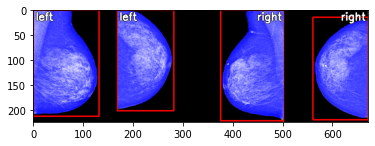

 add_breast_box(): 0/1  0 min 02 secsite_id                                                                 2
patient_id                                                          10008
image_id                                                        736471439
laterality                                                              L
view                                                                  MLO
age                                                                    81
implant                                                                 0
machine_id                                                             21
prediction_id                                                     10008_L
i                                                                       0
TransferSyntaxUID                                  1.2.840.10008.1.2.4.90
pad_breast_box          [0.0, 0.0, 0.5892857142857143, 0.9464285714285...
old_laterality                                                          L
ma

In [7]:
if 'do-breast-box' in mode:
    test_df = test_df.drop([col for col in ['pad_breast_box','max_pad_breast_shape'] if col in test_df.columns], axis=1)

    class PreprocessDataset(Dataset):
        def __init__(self, df):
            self.df = df
            self.length = len(df)
            self.image_size = 224

        def __len__(self):
            return self.length

        def __getitem__(self, index):
            d = self.df.iloc[index]

            m = cv2.imread(f'{png_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png', cv2.IMREAD_GRAYSCALE)
            h, w = m.shape

            s = self.image_size / h
            h, w = int(s * h), int(s * w)
            m = cv2.resize(m, dsize=(w, h), interpolation=cv2.INTER_LINEAR)
            y = (self.image_size - h) // 2
            x = (self.image_size - w) // 2
            rect = (x, y, x + w, y + h)

            image = np.zeros((self.image_size, self.image_size), np.uint8)
            image[y:y + h, x:x + w] = m

            r = {}
            r['index'] = index
            r['d'] = d
            r['rect'] = rect
            r['image'] = torch.from_numpy(image)
            return r

    def proprocess_collate(batch):
        d = {}
        key = batch[0].keys()
        for k in key:
            d[k] = [b[k] for b in batch] 
        d['image'] = torch.stack(d['image'], 0).unsqueeze(1)
        return d

    #--------------------------------------------------------------
    dataset = PreprocessDataset(test_df)
    loader = DataLoader(
        dataset,
        sampler = SequentialSampler(dataset),
        batch_size  = 32,
        drop_last   = False,
        num_workers = 2,
        pin_memory  = False,
        collate_fn = proprocess_collate,
    )

    checkpoint = \
        f'/kaggle/input/rsna-breast-mammography-00/resnet34d-mask-kaggle-005-00000387.model.pth'  # 00000774
    net = PreprocessNet()
    f = torch.load(checkpoint, map_location=lambda storage, loc: storage)
    net.load_state_dict(f['state_dict'],strict=True)
    net.cuda()
    net.eval()

    box = []
    laterality = []

    start_timer = timer()
    for t, batch in enumerate(loader):
        batch_size = len(batch['index'])
        for k in ['image']: batch[k] = batch[k].cuda()
        batch['image'] = batch['image'].half() / 255

        with torch.no_grad():
            with amp.autocast(enabled = True):
                output = net(batch)

        output = post_process(batch, output)
        box.extend(output['box'])
        laterality.extend(output['laterality'])

        if t==0:
            overlay =[]
            for b in range(4):
                
                o = draw_preprocess_overlay(
                    output['image'][b],
                    output['mask'][b],
                    output['box'][b],
                    output['laterality'][b],
                )
                overlay.append(o[...,::-1])

            plt.imshow(np.hstack(overlay))
            plt.show()
 

        print(f'\r add_breast_box(): {t}/{len(loader)} { time_to_str(timer() - start_timer, "sec")}', end='',
              flush=True)
    test_df.loc[:,'pad_breast_box']=box
    test_df.loc[:,'old_laterality']=test_df.laterality.values
    test_df.loc[:,'laterality']=laterality

    def aggr_max_pad_breast_shape(df):
        # print(df)
        box = []
        for t, d in df.iterrows():
            # b = eval(d.pad_breast_box)
            b = d.pad_breast_box
            box.append(b)
        box = np.array(box)

        x0, y0, x1, y1 = box.T
        w = x1 - x0
        h = y1 - y0
        max_pad_breast_box_h = h.max()
        max_pad_breast_box_w = w.max()
        return [max_pad_breast_box_h, max_pad_breast_box_w]

    gb = test_df.groupby('patient_id').apply(aggr_max_pad_breast_shape).to_frame('max_pad_breast_shape')
    gb = gb.reset_index(drop=False)
    test_df = test_df.merge(gb, on=('patient_id'))
  
print(test_df.iloc[0], '\n')
print('gc.collect', gc.collect())
print('')

#print('make_debug_submission')
#make_debug_submission()

In [8]:
def to_list(x):
    if isinstance(x, list): return x
    if isinstance(x, str): return eval(x)

class RsnaDataset(Dataset):
    def __init__(self, df):
        self.length = len(df)
        self.df = df

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        d = self.df.iloc[index]
        m = cv2.imread(f'{png_dir}/{d.machine_id}/{d.patient_id}/{d.image_id}.png',cv2.IMREAD_GRAYSCALE)
        h, w = m.shape
        
        
        image = np.zeros((image_height, image_width), np.uint8) 
        try: #for degenerate case
            xmin, ymin, xmax, ymax = (np.array(to_list(d.pad_breast_box)) * h).astype(int)
            crop = m[ymin:ymax, xmin:xmax]

            mh, mw = (np.array(to_list(d.max_pad_breast_shape)) * h).astype(int)
            scale = min(image_height/mh,  image_width/mw)
            dsize = (min(image_width, int(scale * crop.shape[1])), min(image_height, int(scale * crop.shape[0])))
            if dsize != (crop.shape[1], crop.shape[0]):
                crop = cv2.resize(crop, dsize=dsize, interpolation=cv2.INTER_LINEAR)
            ch,cw = crop.shape  
            x = (image_width  - cw) // 2
            y = (image_height - ch) // 2
            image[y:y + ch, x:x + cw] = crop

        except:
            crop  = m
            scale = min(image_height / h, image_width / w)
            dsize = (min(image_width, int(scale * crop.shape[1])), min(image_height, int(scale * crop.shape[0])))
            if dsize != (crop.shape[1], crop.shape[0]):
                crop = cv2.resize(crop, dsize=dsize, interpolation=cv2.INTER_LINEAR)
            ch, cw = crop.shape
            x = (image_width  - cw) // 2
            y = (image_height - ch) // 2
            image[y:y + ch, x:x + cw] = crop
            

        r = {}
        r['index'] = index
        r['d'] = d
        r['image'] = torch.from_numpy(image)
        return r

def null_collate(batch):
    d = {}
    key = batch[0].keys()
    for k in key:
        d[k] = [b[k] for b in batch]

    d['image'] = torch.stack(d['image']).unsqueeze(1)
    return d

#####################################################################################################

from timm.models.efficientnet import *
from nextvit_bn_merged import *

class NextVitBNet(nn.Module):
    def __init__(self,):
        super(NextVitBNet, self).__init__()
        self.register_buffer('mean', torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1))
        self.register_buffer('std', torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1))
        self.encoder = nextvit_base(pretrained=False)
        self.cancer = nn.Linear(1024,1)

    def forward(self, image):
        x = image
        batch_size,C,H,W = x.shape
        x = (x - self.mean) / self.std

        e = self.encoder.forward_features(x)
        x = F.adaptive_avg_pool2d(e,1)
        x = torch.flatten(x,1,3)
        cancer = self.cancer(x).reshape(-1)
        cancer = torch.sigmoid(cancer)
        return cancer
    
class EffB4Net(nn.Module):
    def __init__(self,):
        super(EffB4Net, self).__init__()
        self.register_buffer('mean', torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1))
        self.register_buffer('std', torch.FloatTensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1))
        self.encoder = efficientnet_b4(pretrained=False, drop_rate=0, drop_path_rate=0)
        self.cancer = nn.Linear(1792,1)

    def forward(self, image):
        x = image
        batch_size,C,H,W = x.shape
        x = (x - self.mean) / self.std

        e = self.encoder.forward_features(x)
        x = F.adaptive_avg_pool2d(e,1)
        x = torch.flatten(x,1,3)
        cancer = self.cancer(x).reshape(-1)
        cancer = torch.sigmoid(cancer)
        return cancer

print('define model ok')

define model ok


In [9]:
batch_size = 4
if 0: #generate trt engine file for development only.
    
    model = NextVitBNet()

    checkpoint = '/kaggle/input/rsna-breast-mammography-weight-10/nextvit-b-1536-gpu-aug0-01-swa.model.pth'
    f = torch.load(checkpoint, map_location=lambda storage, loc: storage)
    model.load_state_dict(f['state_dict'], strict=False)
    model.eval()
    model.encoder.merge_bn()
 
  
    # The compiled module will have precision as specified by "op_precision".
    # import torch_tensorrt
    trt_model_fp16 = torch_tensorrt.compile(
        model,
        inputs=[
            torch_tensorrt.Input(
            [batch_size, 1, image_height, image_width],
            dtype=torch.half
        )],
        enabled_precisions={torch.half},  # Run with FP16
        workspace_size=1 << 32,
        require_full_compilation=True,
    ) 
    torch.jit.save(trt_model_fp16, 'kaggle-nextvit-b-1536-gpu-aug0-01-swa.trt_fp16.ts')
    #compy this file to your own dataset to use again in submission
    print('trt_fp16 ok')
    
    

In [10]:
batch_size = 4 
def run_submit():
    threshold = 0.346938 #0.30612
    
    if 0:  # pytorch fp16
        model = [
            #[EffB4Net,   '/kaggle/input/rsna-breast-mammography-weight-10/effb4-1536-baseline-gpu-aug0-01-swa.model.pth'],
            [NextVitBNet,   '/kaggle/input/rsna-breast-mammography-weight-10/nextvit-b-1536-gpu-aug0-01-swa.model.pth'],

        ]
        num_net = len(model)

        net = []
        for i in range(num_net):
            Net, checkpoint = model[i]
            n = Net()
            f = torch.load(checkpoint, map_location=lambda storage, loc: storage)
            n.load_state_dict(f['state_dict'], strict=False)  # True
            n.encoder.merge_bn()
            n.cuda()
            n.eval()
            net.append(n)
            
    if 1:  # tensort fp16
        model = [
            '/kaggle/input/rsna-breast-mammography-weight-10/kaggle-nextvit-b-1536-gpu-aug0-01-swa.trt_fp16.ts',
            #'/kaggle/working/kaggle-nextvit-b-1536-gpu-aug0-01-swa.trt_fp16.ts'
        ]
        num_net = len(model)

        net = []
        for i in range(num_net):
            n = torch.jit.load(model[i])
            net.append(n)
            
            
            
    # ----
    def pad_to_batch_size(image, batch_size):
        B = len(image)
        if B == batch_size:
            return image, False
        pad = F.pad(input=image, pad=(0, 0, 0, 0, 0, 0, 0, batch_size - B), mode='constant', value=0)
        return pad, True
    
    test_dataset = RsnaDataset(test_df)
    test_loader = DataLoader(
        test_dataset,
        sampler=SequentialSampler(test_dataset),
        batch_size=batch_size,
        drop_last=False,
        num_workers=2,
        pin_memory=True,
        collate_fn=null_collate,
    )

    # ----
    if 1:
        result = {
            'probability': [[] for i in range(num_net)],
        }
        test_num = 0

        start_timer = timer()
        for t, batch in enumerate(test_loader):
            B = len(batch['index'])
            image, is_pad = pad_to_batch_size(batch['image'].cuda().half() / 255, batch_size)
            image0 = image
            image1 = torch.flip(image, dims=[3, ])  # TTA
            #print(image0.shape)
 
            p = 0
            count = 0 
            with torch.no_grad():
                with amp.autocast(enabled=True):
                    for i in range(num_net):
                        p += net[i](image0)
                        count += 1

                        p += net[i](image1)
                        count += 1

            p = p / count
            if is_pad:
                p = p[:B]

            result['probability'].append(p.float().data.cpu().numpy())
            test_num += B
            print('\r %8d / %d  %s' % (test_num, len(test_dataset), time_to_str(timer() - start_timer, 'sec')), end='',
                  flush=True)
            torch.cuda.empty_cache()
        print('')
        # ---
        probability = np.concatenate(result['probability'])
        probability = np.nan_to_num(probability, nan=0, posinf=1, neginf=0)
        np.save('probability.npy', probability)

    ####################################################
    probability = np.load('probability.npy')
    print('probability', probability.shape)
    print('')

    submit_df = pd.DataFrame({
        'prediction_id': test_df.prediction_id,
        'cancer': probability,
    })

    submit_df = submit_df.groupby('prediction_id').mean()
    submit_df = submit_df.sort_index()
    predict = submit_df.cancer.values

    submit_df.loc[:, 'cancer'] = (submit_df.cancer.values > threshold).astype(np.float32)
    predict_threshold = submit_df.cancer.values

    submit_df.to_csv('submission.csv', index=True)
    print('submit_df', submit_df)

    if 'local' in mode:

        def get_f1score(probability, truth, threshold):

            if threshold is None:
                predict = [probability]
            else:
                predict = [
                    (probability > t).astype(np.float32) for t in threshold
                ]

            f1score = []
            for p in predict:
                tp = ((p >= 0.5) & (truth >= 0.5)).sum()
                fp = ((p >= 0.5) & (truth < 0.5)).sum()
                fn = ((p < 0.5) & (truth >= 0.5)).sum()

                recall = tp / (tp + fn + 1e-3)
                precision = tp / (tp + fp + 1e-3)
                f1 = 2 * recall * precision / (recall + precision + 1e-3)
                f1score.append(f1)
            f1score = np.array(f1score)
            return f1score

        truth_df = test_df[['prediction_id', 'cancer']].groupby('prediction_id').mean()
        truth_df = truth_df.sort_index()
        truth = truth_df.cancer.values.astype(int)
        print('truth_df', truth_df)
        print('')

        print(mode)
        auc = metrics.roc_auc_score(truth, predict)
        print('auc', auc)

        thresh  = np.linspace(0, 1, 50)
        f1score = get_f1score(predict, truth, thresh)
        print('f1score.max()', f1score.max())
        print('@threshold', thresh[f1score.argmax()])
        print('')

        f1score = get_f1score(predict_threshold, truth, threshold = None)
        print('f1score', f1score.max())
        print('@threshold', threshold)
        print('')






run_submit() 
print(f'***************ok!')


        4 / 4   0 min 00 sec
probability (4,)

submit_df                cancer
prediction_id        
10008_L           0.0
10008_R           0.0
***************ok!


In [11]:
'''
 

['local', 'do-subset']
auc 0.8894984326018808
f1score.max() 0.7613699425726291
@threshold 0.061224489795918366

f1score 0.5801959128894709
@threshold 0.30612

***************ok!

['local', 'do-dicom-to-png', 'do-breast-box']
10935 / 10935  23 min 23 sec

auc 0.8949804186222482
f1score.max() 0.48569579588239525
@threshold 0.3469387755102041

f1score 0.48569579588239525
@threshold 0.346938

'''

"\n \n\n['local', 'do-subset']\nauc 0.8894984326018808\nf1score.max() 0.7613699425726291\n@threshold 0.061224489795918366\n\nf1score 0.5801959128894709\n@threshold 0.30612\n\n***************ok!\n\n['local', 'do-dicom-to-png', 'do-breast-box']\n10935 / 10935  23 min 23 sec\n\nauc 0.8949804186222482\nf1score.max() 0.48569579588239525\n@threshold 0.3469387755102041\n\nf1score 0.48569579588239525\n@threshold 0.346938\n\n"